In [1]:
import pandas as pd
import numpy as np
import glob
import os
import munge_help
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix,plot_roc_curve,plot_precision_recall_curve,plot_confusion_matrix, classification_report


import utils

import xgboost as xgb

## Loading Data + Classifiers

In [2]:
#processed data
X_train = utils.load_obj(path=os.path.join('data_processed', 'X_train.pkl'))
y_train = utils.load_obj(path=os.path.join('data_processed', 'y_train.pkl'))
X_test = utils.load_obj(path=os.path.join('data_processed', 'X_test.pkl'))
y_test = utils.load_obj(path=os.path.join('data_processed', 'y_test.pkl'))




#paths to download machine learning models
path_f1 = os.path.join('artifacts', 'grid_search_2020-11-29_f1.pkl')
path_precision = os.path.join('artifacts', 'grid_search_2020-11-29_precision.pkl')
path_recall = os.path.join('artifacts', 'grid_search_2020-11-29_recall.pkl')
path_roc = os.path.join('artifacts', 'grid_search_2020-11-29_roc_auc.pkl')
path_ap = os.path.join('artifacts', 'grid_search_2020-11-29_average_precision.pkl')

In [3]:
#load the grid search objects
grid_f1 = utils.load_obj(path_f1)
grid_precision = utils.load_obj(path_precision)
grid_recall = utils.load_obj(path_recall)
grid_roc = utils.load_obj(path_roc)
grid_ap = utils.load_obj(path_ap)

## Best Score By Classifier 


The section below shows the best scores for that particular metric. We also want to see if the grid search prioritizes different hyperparameters based on the classification metric.

In [4]:
parameters = {
    'preprocessor__tfidfvect__max_df': (0.8, 0.9),
    'preprocessor__tfidfvect__min_df': (0.1, 0.15),
    'preprocessor__tfidfvect__max_features': (200, 250),
    'clf__max_depth': (6, 12), #Maximum depth of a tree. Increasing this value will make the model more complex and more likely to overfit
    'clf__subsample': (0.5, 0.9) #take part of train data to avoid overfitting

}

In [5]:
def grid_report(grid_search, parameters):
    print("Best score: %0.3f" % grid_search.best_score_)
    print('\n')
    print(20*'#')
    print('\n')
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

#### F1

In [6]:
grid_report(grid_f1, parameters)

Best score: 0.282


####################


Best parameters set:
	clf__max_depth: 12
	clf__subsample: 0.9
	preprocessor__tfidfvect__max_df: 0.9
	preprocessor__tfidfvect__max_features: 200
	preprocessor__tfidfvect__min_df: 0.1


In [7]:
y_f1 = grid_f1.predict(X_test)

#### Precision

In [8]:
grid_report(grid_precision, parameters)

Best score: 0.212


####################


Best parameters set:
	clf__max_depth: 12
	clf__subsample: 0.9
	preprocessor__tfidfvect__max_df: 0.9
	preprocessor__tfidfvect__max_features: 200
	preprocessor__tfidfvect__min_df: 0.1


In [9]:
y_precision = grid_precision.predict(X_test)

#### Average Precision

In [10]:
grid_report(grid_ap, parameters)

Best score: 0.234


####################


Best parameters set:
	clf__max_depth: 6
	clf__subsample: 0.9
	preprocessor__tfidfvect__max_df: 0.8
	preprocessor__tfidfvect__max_features: 200
	preprocessor__tfidfvect__min_df: 0.15


In [11]:
y_ap = grid_ap.predict(X_test)

#### Recall

In [12]:
grid_report(grid_recall, parameters)

Best score: 0.659


####################


Best parameters set:
	clf__max_depth: 6
	clf__subsample: 0.9
	preprocessor__tfidfvect__max_df: 0.8
	preprocessor__tfidfvect__max_features: 200
	preprocessor__tfidfvect__min_df: 0.15


In [13]:
y_recall = grid_recall.predict(X_test)

### roc

In [14]:
grid_report(grid_roc, parameters)

Best score: 0.894


####################


Best parameters set:
	clf__max_depth: 6
	clf__subsample: 0.5
	preprocessor__tfidfvect__max_df: 0.8
	preprocessor__tfidfvect__max_features: 200
	preprocessor__tfidfvect__min_df: 0.1


In [15]:
y_roc = grid_roc.predict(X_test)

## Plotting

### ROC Curve

Text(0.5, 1.0, 'ROC Curve For XGB Grid Search Metrics')

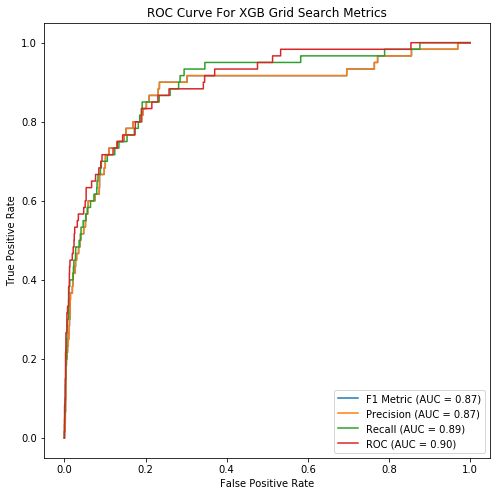

In [16]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()


f1_roc = plot_roc_curve(grid_f1, X_test, y_test, name='F1 Metric', ax=ax)
precision_roc = plot_roc_curve(grid_precision, X_test, y_test, name='Precision', ax=ax)
recall_roc = plot_roc_curve(grid_recall, X_test, y_test, name='Recall', ax=ax)
roc_roc = plot_roc_curve(grid_roc, X_test, y_test, name='ROC', ax=ax)
#ap_roc = plot_roc_curve(grid_ap, X_test, y_test, name='Average Precision', ax=ax)


plt.title("ROC Curve For XGB Grid Search Metrics")

### Precision-Recall Curve

Text(0.5, 1.0, 'Precision-Recall For XGB Grid Search Metrics')

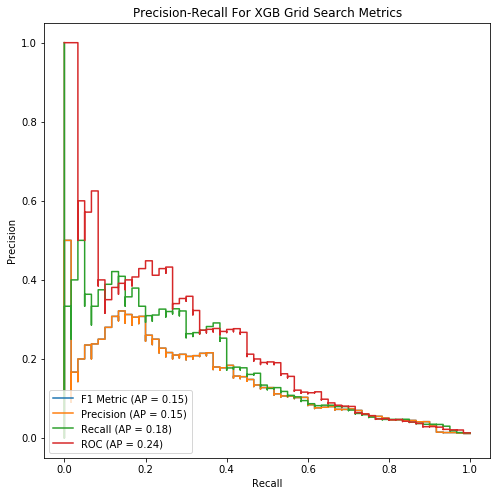

In [17]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()


f1_prc = plot_precision_recall_curve(grid_f1, X_test, y_test, name='F1 Metric', ax=ax)
precision_prc = plot_precision_recall_curve(grid_precision, X_test, y_test, name='Precision', ax=ax)
recall_prc = plot_precision_recall_curve(grid_recall, X_test, y_test, name='Recall', ax=ax)
roc_prc = plot_precision_recall_curve(grid_roc, X_test, y_test, name='ROC', ax=ax)
#ap_prc = plot_precision_recall_curve(grid_ap, X_test, y_test, name='Average Precision', ax=ax)


plt.title("Precision-Recall For XGB Grid Search Metrics")